# Comparing the original TMD with MorphoPy

This notebook will show exemplarily that MorphoPy's implementation of https://github.com/BlueBrain/TMD gives identical results to the original.

The original software is written in Python2.7, thus, it cannot be integrated into this notebook. To reproduce the data used here run a TMD in a virtual environment:

```bash
virtualenv test_tmd
source ./test_tmd/bin/activate
git clone https://github.com/BlueBrain/TMD
pip install ./TMD
```
and convert the reconstructions found in `persistence_test/data/` to persistence diagrams run 

``` python2 .create_persistence_diagrams_using_tmd.py ```

Please note: 
If several soma points are present in a reconstruction, MorphoPy's default behavior is to collapse them all into their center of mass. This can lead to differences between the TMD original package, which represents soma points and neurites separately. If you want to remove the soma's influence on the computed feature please refer to the `get_neurites()` method.

In [10]:
import os
import pandas as pd
import numpy as np
import copy 

# To delete when installation works
import sys
sys.path.append("../../")

import morphopy.neurontree.NeuronTree as nt
from morphopy.neurontree.utils import get_standardized_swc
import morphopy.computation.feature_presentation as fp

import matplotlib.pyplot as plt
import seaborn as sns

In [11]:
import networkx as nx

nx_version == nx.__version__
# A selection of filter functions
def radial_distance(G, u, v):
    if nx_version > 1:
        # changed for version 2.x of networkX
        n = G.nodes[u]['pos']
        r = G.nodes[v]['pos']
    else:
        n = G.node[u]['pos']
        r = G.node[v]['pos']

    return np.sqrt(np.dot(n - r, n - r))

def height(G, u, v):
    if nx_version > 1:
        # changed for version 2.x of networkX
        n = G.nodes[u]['pos']
        r = G.nodes[v]['pos']
    else:
        n = G.node[u]['pos']
        r = G.node[v]['pos']
        
    return np.abs((n - r))[2]

def projection(G,u,v):
    if nx_version > 1:
        # changed for version 2.x of networkX
        r = G.nodes[u]['pos']
        p = G.nodes[v]['pos']
    else:
        r = G.node[u]['pos']
        p = G.node[v]['pos']
        
    n = np.array([0,1,0])
    return np.dot(r-p,n)

import networkx as nx

def path_length(G, u, v):
    return nx.shortest_path_length(G, v, u, weight='path_length')

def branch_order(G,u,v):
    
    if u == v:
        bo = 0
    else:
        path = nx.shortest_path(G, v, u)
        path.remove(u)
        bo = np.sum(np.array(list(nx.degree(G, path).values())) > 2)
    return bo

NameError: name 'nx_version' is not defined

In [3]:
root, _ , files = list(os.walk("./data/"))[0]
features = [radial_distance, path_length, projection, branch_order]

In [4]:
trees = []
for file in files:
    swc = pd.read_csv("./data/"+file,delim_whitespace=True, comment='#',
                              names=['n', 'type', 'x', 'y', 'z', 'radius', 'parent'], index_col=False)
    swc = get_standardized_swc(swc, pca_rot=False)
    N = nt.NeuronTree(swc)
    
    trees.append(N)

There are more than 3 soma points. The location and the radius of the soma is estimated based on its convex hull...


/usr/local/lib/python3.5/dist-packages/pandas/core/frame.py:6701: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


There are 2-3 soma points. The location and the radius of the soma is estimated based on their mean.


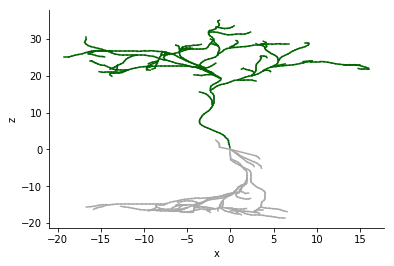

In [5]:
# Draw one of the investigated neurons

N.draw_2D(projection='xz')
sns.despine()
plt.xlabel('x')
plt.ylabel('z')

In [6]:
files

['eNGC-j140908b_cell1.swc',
 'test_neuron.swc',
 'C010398B-P2.CNG.swc',
 'C4.swc',
 'ds_1_cell_390.swc']

In [7]:

persistence_diagrams = []
for N in trees:
    
    #since TMD works without the soma only get neurites
    neurites = N.get_neurites(soma_included=False)
    
    p = dict()
    for feature in features:
        df = pd.DataFrame()
        for n in neurites: 
            df = df.append(fp.get_persistence(n, f=feature))
        
        p[feature.__name__] = copy.copy(df)
    persistence_diagrams.append(p)

NameError: name 'nx_version' is not defined

In [ ]:
# Draw the persistence results for TMD and MorphoPy

for ix in range(len(files)):
   
    test_neuron = files[ix]
    tmd_files = [s%test_neuron.split(".")[0] for s in ['%s_radial_distances.txt', '%s_path_distances.txt',
                 '%s_projection.txt', '%s_section_branch_orders.txt']]

    k = 0
    plt.figure(figsize=(20,5))

    for tmd_file in tmd_files:
        df = pd.read_csv("./diagrams/" + tmd_file, header=None, sep=" ")

        f = features[k]
        A = df
        B = persistence_diagrams[ix][f.__name__]

        plt.subplot(1,4,k+1)
        plt.scatter(np.round(A[0],2), np.round(A[1],2), marker='s', c='blue', label='TMD')

        plt.scatter(np.round(B['birth'],2),np.round(B['death'],2),marker='.', c='orange', label='MorphoPy')


        sns.despine()
        plt.title(f.__name__)
        plt.xlabel('birth')
        plt.ylabel('death')

        if k == 0:
            plt.legend()

        k +=1
    plt.suptitle(files[ix], weight='bold')
